1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [3]:
import pandas as pd

file_name = "data/data_000637.txt"
data = pd.read_csv(file_name)
print(data)

N = 1310720  # equal to the maximum number of rows and larger than 10k
data = data[:N]  # we choose all the data
print(data)

         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0           1     0          123  3869200167        2374        26
1           1     0          124  3869200167        2374        27
2           1     0           63  3869200167        2553        28
3           1     0           64  3869200167        2558        19
4           1     0           64  3869200167        2760        25
...       ...   ...          ...         ...         ...       ...
1310715     1     0           62  3869211171         762        14
1310716     1     1            4  3869211171         763        11
1310717     1     0           64  3869211171         764         0
1310718     1     0          139  3869211171         769         0
1310719     1     0           61  3869211171         762        18

[1310720 rows x 6 columns]
         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0           1     0          123  3869200167        2374        26
1           1     0          124  

2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [4]:
x = data['BX_COUNTER'].max()
print(f"Estimation of the number of BX in an ORBIT: x = {x}")

Estimation of the number of BX in an ORBIT: x = 3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

*Hint:* introduce an offset to the absolute time such that the start of the data acquisition (i.e. the first entry) is zero.

In [5]:
# Calculate the absolute time ins ns
data["ABSOLUTE_TIME"] = data["ORBIT_CNT"]*x*25 + data["BX_COUNTER"]*25 + data["TDC_MEAS"]*25/30
# Introduce an offset to make it zero
offset = data["ABSOLUTE_TIME"][0]
data["ABSOLUTE_TIME"] -= offset
# Convert absolute time column to a Time Series
data["ABSOLUTE_TIME"] = pd.to_datetime(data["ABSOLUTE_TIME"], unit='ns')
print(data)

         HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS  \
0           1     0          123  3869200167        2374        26   
1           1     0          124  3869200167        2374        27   
2           1     0           63  3869200167        2553        28   
3           1     0           64  3869200167        2558        19   
4           1     0           64  3869200167        2760        25   
...       ...   ...          ...         ...         ...       ...   
1310715     1     0           62  3869211171         762        14   
1310716     1     1            4  3869211171         763        11   
1310717     1     0           64  3869211171         764         0   
1310718     1     0          139  3869211171         769         0   
1310719     1     0           61  3869211171         762        18   

                        ABSOLUTE_TIME  
0       1970-01-01 00:00:00.000000000  
1       1970-01-01 00:00:00.000000000  
2       1970-01-01 00:00:00.000004476  

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [6]:
duration = data["ABSOLUTE_TIME"].max()
print(duration)

hours = duration.hour
minutes = duration.minute
seconds = duration.second
print(f"\nDuration of data taking: {hours} hours, {minutes} minutes, {seconds} seconds.")

1970-01-01 00:00:00.980141153

Duration of data taking: 0 hours, 0 minutes, 0 seconds.


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [7]:
noisy_channels = data.groupby("TDC_CHANNEL").count()
noisy_channels = noisy_channels.sort_values(by="HEAD", ascending=False)
print(f"Noisy channels:\n{noisy_channels.head(3)["HEAD"]}")

Noisy channels:
TDC_CHANNEL
139    108059
64      66020
63      64642
Name: HEAD, dtype: int64


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [8]:
non_empty_orbits_count = len(data.groupby('ORBIT_CNT'))
print(f"Number of non-empty orbits: {non_empty_orbits_count}")

Number of non-empty orbits: 11001


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [9]:
unique_orbits_139 = len(data[data["TDC_CHANNEL"]==139].groupby("ORBIT_CNT"))
print(f"Number of unique orbits with TDC_CHANNEL=139: {unique_orbits_139}")

Number of unique orbits with TDC_CHANNEL=139: 10976


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [10]:
data_0 = data[data["FPGA"]==0].groupby("TDC_CHANNEL")["FPGA"].count()
data_1 = data[data["FPGA"]==1].groupby("TDC_CHANNEL")["FPGA"].count()
print(f"Counts for FPGA 0:\n{data_0}")
print(f"Counts for FPGA 1:\n{data_1}")

Counts for FPGA 0:
TDC_CHANNEL
1       1215
2       1602
3       1493
4       2352
5       1432
       ...  
129        2
130       33
137       32
138       34
139    75617
Name: FPGA, Length: 124, dtype: int64
Counts for FPGA 1:
TDC_CHANNEL
1      28438
2      32669
3      21970
4      26403
5      15003
       ...  
129       35
130       38
137       36
138       36
139    32442
Name: FPGA, Length: 132, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

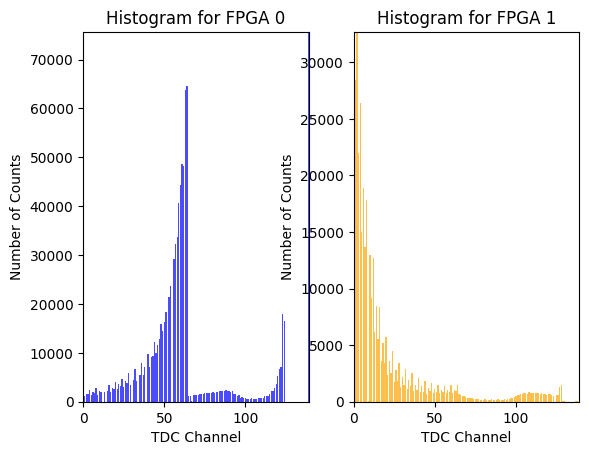

In [11]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.bar(data_0.index, data_0, color='blue', alpha=0.7)
plt.title('Histogram for FPGA 0')
plt.xlabel('TDC Channel')
plt.ylabel('Number of Counts')
plt.xlim(0, max(data_0.index))
plt.ylim(0, max(data_0))

plt.subplot(1, 2, 2)
plt.bar(data_1.index, data_1, color='orange', alpha=0.7)
plt.title('Histogram for FPGA 1')
plt.xlabel('TDC Channel')
plt.ylabel('Number of Counts')
plt.xlim(0, max(data_1.index))
plt.ylim(0, max(data_1))

plt.show()